# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


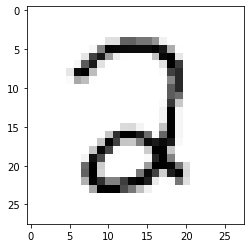

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2539
Training Accuracy: 0.5086, Testing Accuracy: 0.5318



Epoch 10, Loss 0.1843
Training Accuracy: 0.8865, Testing Accuracy: 0.8967



Epoch 20, Loss 0.0908
Training Accuracy: 0.9169, Testing Accuracy: 0.9289



Epoch 30, Loss 0.0603
Training Accuracy: 0.9380, Testing Accuracy: 0.9466



Epoch 40, Loss 0.0479
Training Accuracy: 0.9476, Testing Accuracy: 0.9551



Epoch 50, Loss 0.0414
Training Accuracy: 0.9522, Testing Accuracy: 0.9627



Epoch 60, Loss 0.0374
Training Accuracy: 0.9573, Testing Accuracy: 0.9652



Epoch 70, Loss 0.0347
Training Accuracy: 0.9598, Testing Accuracy: 0.9672



Epoch 80, Loss 0.0326
Training Accuracy: 0.9617, Testing Accuracy: 0.9672



Epoch 90, Loss 0.031
Training Accuracy: 0.9637, Testing Accuracy: 0.9688



Epoch 100, Loss 0.0297
Training Accuracy: 0.9651, Testing Accuracy: 0.9688



Epoch 110, Loss 0.0286
Training Accuracy: 0.9659, Testing Accuracy: 0.9682



Epoch 120, Loss 0.0276
Training Accuracy: 0.9670, Testing Accuracy: 0.9682



Epoch 130, Loss 0.0267
Training Accuracy: 0.9682, Testing Accuracy: 0.9677



Epoch 140, Loss 0.0259
Training Accuracy: 0.9690, Testing Accuracy: 0.9688



Epoch 150, Loss 0.0252
Training Accuracy: 0.9698, Testing Accuracy: 0.9698



Epoch 160, Loss 0.0245
Training Accuracy: 0.9709, Testing Accuracy: 0.9698



Epoch 170, Loss 0.0239
Training Accuracy: 0.9716, Testing Accuracy: 0.9698



Epoch 180, Loss 0.0234
Training Accuracy: 0.9721, Testing Accuracy: 0.9708



Epoch 190, Loss 0.0228
Training Accuracy: 0.9726, Testing Accuracy: 0.9703



Epoch 200, Loss 0.0223
Training Accuracy: 0.9737, Testing Accuracy: 0.9698



Epoch 210, Loss 0.0218
Training Accuracy: 0.9742, Testing Accuracy: 0.9708



Epoch 220, Loss 0.0214
Training Accuracy: 0.9752, Testing Accuracy: 0.9708



Epoch 230, Loss 0.021
Training Accuracy: 0.9760, Testing Accuracy: 0.9713



Epoch 240, Loss 0.0205
Training Accuracy: 0.9765, Testing Accuracy: 0.9728



0.07347492709772754

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2223
Training Accuracy: 0.7672, Testing Accuracy: 0.7505



Epoch 10, Loss 0.1012
Training Accuracy: 0.9127, Testing Accuracy: 0.9239



Epoch 20, Loss 0.0787
Training Accuracy: 0.9273, Testing Accuracy: 0.9385



Epoch 30, Loss 0.0681
Training Accuracy: 0.9357, Testing Accuracy: 0.9481



Epoch 40, Loss 0.0617
Training Accuracy: 0.9392, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0574
Training Accuracy: 0.9437, Testing Accuracy: 0.9541



Epoch 60, Loss 0.0541
Training Accuracy: 0.9455, Testing Accuracy: 0.9572



Epoch 70, Loss 0.0516
Training Accuracy: 0.9481, Testing Accuracy: 0.9577



Epoch 80, Loss 0.0496
Training Accuracy: 0.9492, Testing Accuracy: 0.9587



Epoch 90, Loss 0.0479
Training Accuracy: 0.9507, Testing Accuracy: 0.9592



Epoch 100, Loss 0.0465
Training Accuracy: 0.9513, Testing Accuracy: 0.9602



Epoch 110, Loss 0.0453
Training Accuracy: 0.9533, Testing Accuracy: 0.9622



Epoch 120, Loss 0.0442
Training Accuracy: 0.9543, Testing Accuracy: 0.9632



Epoch 130, Loss 0.0433
Training Accuracy: 0.9549, Testing Accuracy: 0.9632



Epoch 140, Loss 0.0424
Training Accuracy: 0.9553, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0417
Training Accuracy: 0.9556, Testing Accuracy: 0.9637



Epoch 160, Loss 0.041
Training Accuracy: 0.9564, Testing Accuracy: 0.9642



Epoch 170, Loss 0.0404
Training Accuracy: 0.9569, Testing Accuracy: 0.9642



Epoch 180, Loss 0.0398
Training Accuracy: 0.9575, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0393
Training Accuracy: 0.9581, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0388
Training Accuracy: 0.9584, Testing Accuracy: 0.9667



Epoch 210, Loss 0.0384
Training Accuracy: 0.9591, Testing Accuracy: 0.9672



Epoch 220, Loss 0.038
Training Accuracy: 0.9594, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0376
Training Accuracy: 0.9596, Testing Accuracy: 0.9677



Epoch 240, Loss 0.0372
Training Accuracy: 0.9599, Testing Accuracy: 0.9677



0.014227082534545384

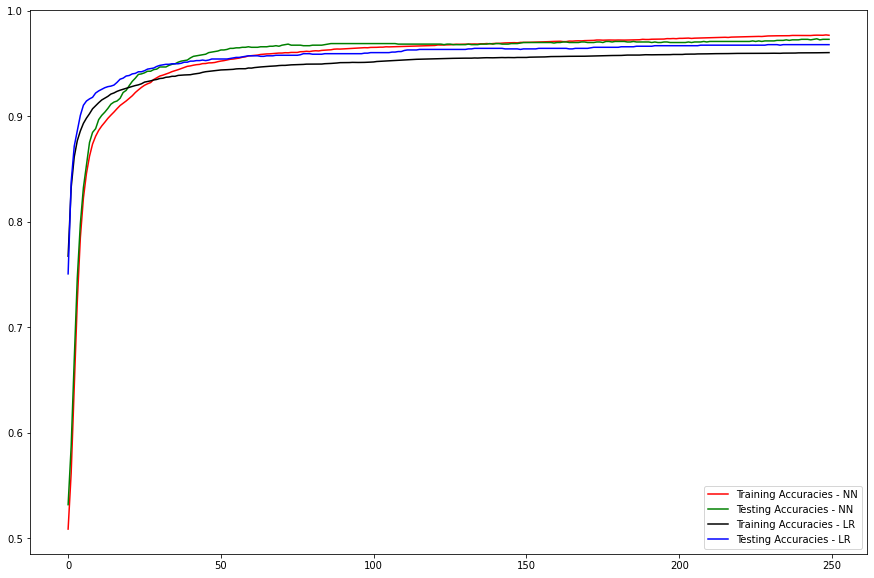

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

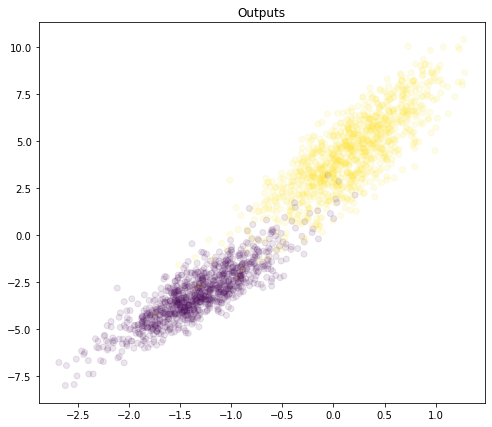

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

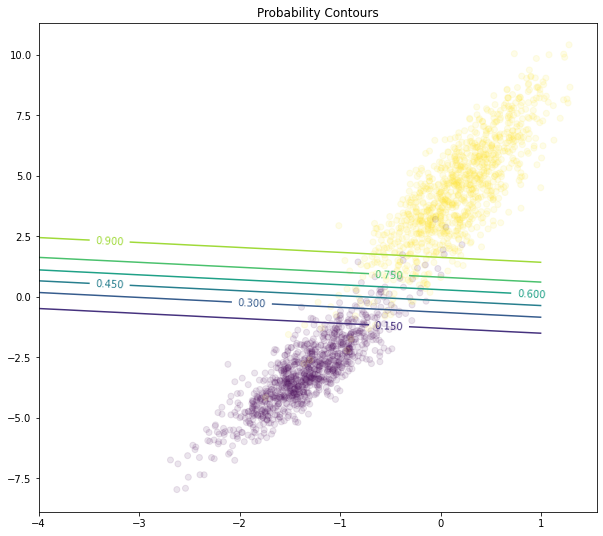

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );